# COVID-19 Prediction Analysis

In [1]:
# Suppress warning messages
import warnings 
warnings.filterwarnings('ignore')

In [2]:
# Import general dependencies
import os 
import pandas as pd
from pprint import pprint
from pathlib import Path
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import datetime

In [ ]:
# #Import connection dependencies
# import sqlalchemy
# from sqlalchemy.ext.automap import automap_base
# from sqlalchemy.orm import Session
# from sqlalchemy import create_engine, func
# import psycopg2

In [3]:
# Import machine learning dependencies 
import sklearn as skl
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
# from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn import metrics 
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint
import seaborn as sns
# import keras_tuner as kt

### Data Source

**Our World in Data COVID-19 Dataset Citation**
Hannah Ritchie, Edouard Mathieu, Lucas Rodés-Guirao, Cameron Appel, Charlie Giattino, Esteban Ortiz-Ospina, Joe Hasell, Bobbie Macdonald, Diana Beltekian and Max Roser (2020) - "Coronavirus Pandemic (COVID-19)". Published online at OurWorldInData.org. Retrieved from: [Our World In Data / Coronavirus](https://ourworldindata.org/coronavirus)

The OWID COVID-19 data entry started on January 1st, 2020 and has been daily updated till July 4th, 2022 when we pulled the dataset from the [OWID/COVID-19-data GitHub Repository](https://github.com/owid/covid-19-data/tree/master/public/data).

In [4]:
# Load the cases prediction cleaned data file.
cases_file_path = Path('./Resources/cases_pred.csv')
df = pd.read_csv(cases_file_path)
print(df.shape)
df.head()

(112069, 30)


,id_row,location,covid_days,total_cases,new_cases,new_cases_smoothed,new_cases_smoothed_per_million,reproduction_rate,total_vaccinations,people_fully_vaccinated,...,life_expectancy,human_development_index,daily_vaccinations,daily_people_fully_vaccinated,total_cases_per_100K,new_cases_per_100K,total_vaccinations_per_100K,people_fully_vaccinated_per_100K,daily_vaccinations_per_100K,daily_people_fully_vaccinated_per_100K
0,34,Afghanistan,88,114.0,8.0,11.429,0.287,1.52,0.0,0.0,...,64.83,0.511,0.0,0.0,0.2862,0.0201,0.0,0.0,0.0,0.0
1,35,Afghanistan,89,114.0,0.0,10.571,0.265,1.52,0.0,0.0,...,64.83,0.511,0.0,0.0,0.2862,0.0000,0.0,0.0,0.0,0.0
2,36,Afghanistan,90,166.0,52.0,17.714,0.445,1.53,0.0,0.0,...,64.83,0.511,0.0,0.0,0.4167,0.1305,0.0,0.0,0.0,0.0
3,37,Afghanistan,91,192.0,26.0,16.857,0.423,1.52,0.0,0.0,...,64.83,0.511,0.0,0.0,0.4820,0.0653,0.0,0.0,0.0,0.0
4,38,Afghanistan,92,235.0,43.0,22.143,0.556,1.52,0.0,0.0,...,64.83,0.511,0.0,0.0,0.5899,0.1079,0.0,0.0,0.0,0.0


In [5]:
# Set the id_row column as index and reorder records by id.
df = df.set_index('id_row').sort_values(by='id_row')
print(df.shape)
df.head()

(112069, 29)


,location,covid_days,total_cases,new_cases,new_cases_smoothed,new_cases_smoothed_per_million,reproduction_rate,total_vaccinations,people_fully_vaccinated,stringency_index,...,life_expectancy,human_development_index,daily_vaccinations,daily_people_fully_vaccinated,total_cases_per_100K,new_cases_per_100K,total_vaccinations_per_100K,people_fully_vaccinated_per_100K,daily_vaccinations_per_100K,daily_people_fully_vaccinated_per_100K
id_row,,,,,,,,,,,,,,,,,,,,,
34,Afghanistan,88,114.0,8.0,11.429,0.287,1.52,0.0,0.0,67.59,...,64.83,0.511,0.0,0.0,0.2862,0.0201,0.0,0.0,0.0,0.0
35,Afghanistan,89,114.0,0.0,10.571,0.265,1.52,0.0,0.0,67.59,...,64.83,0.511,0.0,0.0,0.2862,0.0000,0.0,0.0,0.0,0.0
36,Afghanistan,90,166.0,52.0,17.714,0.445,1.53,0.0,0.0,67.59,...,64.83,0.511,0.0,0.0,0.4167,0.1305,0.0,0.0,0.0,0.0
37,Afghanistan,91,192.0,26.0,16.857,0.423,1.52,0.0,0.0,67.59,...,64.83,0.511,0.0,0.0,0.4820,0.0653,0.0,0.0,0.0,0.0
38,Afghanistan,92,235.0,43.0,22.143,0.556,1.52,0.0,0.0,67.59,...,64.83,0.511,0.0,0.0,0.5899,0.1079,0.0,0.0,0.0,0.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 112069 entries, 34 to 198747
Data columns (total 29 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   location                                112069 non-null  object 
 1   covid_days                              112069 non-null  int64  
 2   total_cases                             112069 non-null  float64
 3   new_cases                               112069 non-null  float64
 4   new_cases_smoothed                      111964 non-null  float64
 5   new_cases_smoothed_per_million          111964 non-null  float64
 6   reproduction_rate                       112069 non-null  float64
 7   total_vaccinations                      112069 non-null  float64
 8   people_fully_vaccinated                 112069 non-null  float64
 9   stringency_index                        112069 non-null  float64
 10  population                              112

To predict the daily number of new COVID-19 cases, we will focus on processing the following columns and creating new features off of these: (**total_cases, new_cases, total_cases_per_100K, new_cases_per_100K, reproduction_rate, total_vaccinations, people_fully_vaccinated, total_vaccinations_per_100K, people_fully_vaccinated_per_100K, stringency_index, population, population_density, median_age, aged_65_older, gdp_per_capita, cardiovasc_death_rate, diabetes_prevalence, life_expectancy, human_development_index, daily_vacciantions, daily_people_fully_vaccinated, daily_vaccinations_per_100K, daily_people_fully_vaccinated_per_100K**). 

We presume that vaccination  has played an integral role in the COVID-19 pandemic trajectory, and its influence may be observed over both COVID-19 cases and deaths.

We will not be using smoothed numbers for now, but we will leave these columns in a separate dataframe that contains averages in case we were able to revisit the code and run a more elaborate feature engineering including calculating rolling averages of daily vaccines and people_fully_vaccinated. At that point, we could use the cleaned dataframe and handle the missing values of the smoothed columns: (**new_cases_smoothed, new_cases_smoothed_per_million, new_vaccinations_smoothed, new_vaccinations_smoothed_per_million**).

The reason we will leave **female_smokers** and **male_smokers** out of the new_cases prediction features for now is the substantial number of missing values. 
*Reconsider* including **female_smokers**, and **male_smokers** in the features for new_cases prediction model if the model needs feature enhancement. The logic behind it is that smokers might be more symptomatic when infected with COVID-19, hence they seek testing and that would increase the documented number of the cases. Same concept applies to the populations' rates of cardiovascular_death and diabetes_prevalence. 

In [7]:
# Drop unnecessary columns.
cols_drop = ['new_cases_smoothed', 'new_cases_smoothed_per_million',
            'female_smokers', 'male_smokers']
focused_general_df = df.drop(columns=cols_drop, axis=1)
print(focused_general_df.shape) 
focused_general_df.info()

(112069, 25)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 112069 entries, 34 to 198747
Data columns (total 25 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   location                                112069 non-null  object 
 1   covid_days                              112069 non-null  int64  
 2   total_cases                             112069 non-null  float64
 3   new_cases                               112069 non-null  float64
 4   reproduction_rate                       112069 non-null  float64
 5   total_vaccinations                      112069 non-null  float64
 6   people_fully_vaccinated                 112069 non-null  float64
 7   stringency_index                        112069 non-null  float64
 8   population                              112069 non-null  float64
 9   population_density                      112069 non-null  float64
 10  median_age                    

In [8]:
# Check missing values in the focused dataframe
focused_general_df.isnull().sum()

location                                   0
covid_days                                 0
total_cases                                0
new_cases                                  0
reproduction_rate                          0
total_vaccinations                         0
people_fully_vaccinated                    0
stringency_index                           0
population                                 0
population_density                         0
median_age                                 0
aged_65_older                              0
gdp_per_capita                             0
cardiovasc_death_rate                      0
diabetes_prevalence                        0
life_expectancy                            0
human_development_index                    0
daily_vaccinations                         0
daily_people_fully_vaccinated              0
total_cases_per_100K                       0
new_cases_per_100K                        78
total_vaccinations_per_100K                0
people_ful

In [9]:
# Check missing values from new_cases_per_100K
check_df = focused_general_df[['new_cases', 'population', 'new_cases_per_100K']]
see_nulls = check_df.loc[check_df.new_cases_per_100K.isnull()]
see_nulls.head(10)

,new_cases,population,new_cases_per_100K
id_row,,,
679,0.0,3.983543e+07,NaN
6400,0.0,9.872800e+04,NaN
11096,0.0,2.578822e+07,NaN
11112,0.0,2.578822e+07,NaN
13572,0.0,3.969140e+05,NaN
18998,0.0,1.245103e+07,NaN
24929,0.0,2.139934e+08,NaN
25383,0.0,2.139934e+08,NaN
27143,0.0,4.415320e+05,NaN


In [10]:
# Replace the missing values in the normalized new_cases_per_100K column with a rate calculation.
focused_general_df.new_cases_per_100K.fillna(focused_general_df.new_cases / focused_general_df.population * 100000, inplace=True)
focused_general_df.isnull().sum()

location                                  0
covid_days                                0
total_cases                               0
new_cases                                 0
reproduction_rate                         0
total_vaccinations                        0
people_fully_vaccinated                   0
stringency_index                          0
population                                0
population_density                        0
median_age                                0
aged_65_older                             0
gdp_per_capita                            0
cardiovasc_death_rate                     0
diabetes_prevalence                       0
life_expectancy                           0
human_development_index                   0
daily_vaccinations                        0
daily_people_fully_vaccinated             0
total_cases_per_100K                      0
new_cases_per_100K                        0
total_vaccinations_per_100K               0
people_fully_vaccinated_per_100K

## Data Exploration

In [11]:
# Count the number of locations in the focused_general_df
print(f"There are {focused_general_df.location.nunique()} locations in the cleaned dataframe.")

There are 177 locations in the cleaned dataframe.


In [12]:
# Check the date range. 
focused_general_df.covid_days.sort_values()

id_row
36732      22
36733      23
36734      24
36735      25
36736      26
         ... 
94986     817
94573     817
6723      817
99223     817
198747    817
Name: covid_days, Length: 112069, dtype: int64

The cleaned dataframe contained location_specific COVID-19 entries starting at day 22nd of the pandemic, and up to day 817th of the pandemic. 

In [13]:
# Check the count of records for each location
locations_records = focused_general_df.location.value_counts()
locations_records

South Korea        767
Italy              764
Singapore          758
France             758
Germany            757
                  ... 
Kiribati            55
Solomon Islands     51
Tonga               39
Vanuatu             18
Samoa                6
Name: location, Length: 177, dtype: int64

<AxesSubplot:ylabel='Density'>

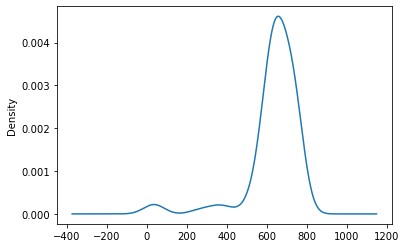

In [14]:
# Visualize locations' records.
locations_records.plot.density()

In [15]:
# Check the population range in the cleaned dataframe.
print(f"Population min: {focused_general_df.population.min()}")
print(f"Population max: {focused_general_df.population.max()}")

Population min: 98728.0
Population max: 1444216102.0


### Population Splitting

To facilitate the machine learning model application, we split the dataset based on population and applied the model to countries with populations of 1 million and above.

Create a population-based DataFrame: 
- mill_countries_df: Population more than 1 million.

#### Population 1 million and above

In [16]:
# Create 1 million and above population DataFrame for cases_pred_df.
cases_mill_countries_df = focused_general_df[(focused_general_df["population"] >= 1000000)]
print(cases_mill_countries_df.shape)
cases_mill_countries_df.head()

(99856, 25)


,location,covid_days,total_cases,new_cases,reproduction_rate,total_vaccinations,people_fully_vaccinated,stringency_index,population,population_density,...,life_expectancy,human_development_index,daily_vaccinations,daily_people_fully_vaccinated,total_cases_per_100K,new_cases_per_100K,total_vaccinations_per_100K,people_fully_vaccinated_per_100K,daily_vaccinations_per_100K,daily_people_fully_vaccinated_per_100K
id_row,,,,,,,,,,,,,,,,,,,,,
34,Afghanistan,88,114.0,8.0,1.52,0.0,0.0,67.59,39835428.0,54.422,...,64.83,0.511,0.0,0.0,0.2862,0.0201,0.0,0.0,0.0,0.0
35,Afghanistan,89,114.0,0.0,1.52,0.0,0.0,67.59,39835428.0,54.422,...,64.83,0.511,0.0,0.0,0.2862,0.0000,0.0,0.0,0.0,0.0
36,Afghanistan,90,166.0,52.0,1.53,0.0,0.0,67.59,39835428.0,54.422,...,64.83,0.511,0.0,0.0,0.4167,0.1305,0.0,0.0,0.0,0.0
37,Afghanistan,91,192.0,26.0,1.52,0.0,0.0,67.59,39835428.0,54.422,...,64.83,0.511,0.0,0.0,0.4820,0.0653,0.0,0.0,0.0,0.0
38,Afghanistan,92,235.0,43.0,1.52,0.0,0.0,67.59,39835428.0,54.422,...,64.83,0.511,0.0,0.0,0.5899,0.1079,0.0,0.0,0.0,0.0


In [17]:
# Check the names and count of countries with population more than 1 mill.
cases_mill_countries_list = cases_mill_countries_df["location"].unique()
print(f" There are {len(cases_mill_countries_list)} countries with population of 1 million and above.")
cases_mill_countries_list

 There are 150 countries with population of 1 million and above.


array(['Afghanistan', 'Albania', 'Algeria', 'Angola', 'Argentina',
       'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahrain',
       'Bangladesh', 'Belarus', 'Belgium', 'Benin', 'Bolivia',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Bulgaria',
       'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon', 'Canada',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Congo', 'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Czechia',
       'Democratic Republic of Congo', 'Denmark', 'Djibouti',
       'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador',
       'Equatorial Guinea', 'Eritrea', 'Estonia', 'Eswatini', 'Ethiopia',
       'Finland', 'France', 'Gabon', 'Gambia', 'Georgia', 'Germany',
       'Ghana', 'Greece', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Haiti',
       'Honduras', 'Hungary', 'India', 'Indonesia', 'Iran', 'Iraq',
       'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan', 'Jordan',
       'Kazakhstan', 'Kenya', 'Kuwait', 'Kyrgyz

In [18]:
# Check the records count of 1 million+ countries.
cases_mill_pop_records = cases_mill_countries_df.location.value_counts()
cases_mill_pop_records

South Korea         767
Italy               764
Singapore           758
France              758
Germany             757
                   ... 
Botswana            549
Papua New Guinea    543
Angola              543
Timor               327
Laos                279
Name: location, Length: 150, dtype: int64

##### PHASE 1 DATAFRAME:  apply only on countries with population of 1 million and above.

In [19]:
cases_mill_countries_df.shape

(99856, 25)

In [20]:
cases_mill_countries_df.location.nunique()

150

In [21]:
cases_mill_countries_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99856 entries, 34 to 198747
Data columns (total 25 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   location                                99856 non-null  object 
 1   covid_days                              99856 non-null  int64  
 2   total_cases                             99856 non-null  float64
 3   new_cases                               99856 non-null  float64
 4   reproduction_rate                       99856 non-null  float64
 5   total_vaccinations                      99856 non-null  float64
 6   people_fully_vaccinated                 99856 non-null  float64
 7   stringency_index                        99856 non-null  float64
 8   population                              99856 non-null  float64
 9   population_density                      99856 non-null  float64
 10  median_age                              99856 non-null  

In [ ]:
# # Export the cases prediction DataFrame of countries with 1 mill+ to a csv file.
# cases_1mill_output_file = Path("./Resources/cases_1mill_pred.csv")
# cases_mill_countries_df.to_csv(cases_1mill_output_file, index=True)

## Covid Days Splitting

In light of the changing nature of the COVID-19 virus and the emergent new variants, we will be looking at data from the first 2 years of the pandemic when the public health measures were more strict. 

In [22]:
# Create a 2-yr (720) DataFrame 
cases_1mill_2yr_df = cases_mill_countries_df[cases_mill_countries_df["covid_days"] <= 725]
print(cases_1mill_2yr_df.shape)
cases_1mill_2yr_df.head()

(88039, 25)


,location,covid_days,total_cases,new_cases,reproduction_rate,total_vaccinations,people_fully_vaccinated,stringency_index,population,population_density,...,life_expectancy,human_development_index,daily_vaccinations,daily_people_fully_vaccinated,total_cases_per_100K,new_cases_per_100K,total_vaccinations_per_100K,people_fully_vaccinated_per_100K,daily_vaccinations_per_100K,daily_people_fully_vaccinated_per_100K
id_row,,,,,,,,,,,,,,,,,,,,,
34,Afghanistan,88,114.0,8.0,1.52,0.0,0.0,67.59,39835428.0,54.422,...,64.83,0.511,0.0,0.0,0.2862,0.0201,0.0,0.0,0.0,0.0
35,Afghanistan,89,114.0,0.0,1.52,0.0,0.0,67.59,39835428.0,54.422,...,64.83,0.511,0.0,0.0,0.2862,0.0000,0.0,0.0,0.0,0.0
36,Afghanistan,90,166.0,52.0,1.53,0.0,0.0,67.59,39835428.0,54.422,...,64.83,0.511,0.0,0.0,0.4167,0.1305,0.0,0.0,0.0,0.0
37,Afghanistan,91,192.0,26.0,1.52,0.0,0.0,67.59,39835428.0,54.422,...,64.83,0.511,0.0,0.0,0.4820,0.0653,0.0,0.0,0.0,0.0
38,Afghanistan,92,235.0,43.0,1.52,0.0,0.0,67.59,39835428.0,54.422,...,64.83,0.511,0.0,0.0,0.5899,0.1079,0.0,0.0,0.0,0.0


In [23]:
# # Export the cases prediction DataFrame of countries with 1 mill+ and 720 covid_days to a csv file.
# cases_1mill_2yr_output_file = Path("./Resources/cases_1mill_2yr_df.csv")
# cases_1mill_2yr_df.to_csv(cases_1mill_2yr_output_file, index=True)

In [24]:
# Create a 700 days DataFrame 
cases_1mill_700_df = cases_mill_countries_df[cases_mill_countries_df["covid_days"] <= 700]
print(cases_1mill_700_df.shape)
cases_1mill_700_df.head()

(84848, 25)


,location,covid_days,total_cases,new_cases,reproduction_rate,total_vaccinations,people_fully_vaccinated,stringency_index,population,population_density,...,life_expectancy,human_development_index,daily_vaccinations,daily_people_fully_vaccinated,total_cases_per_100K,new_cases_per_100K,total_vaccinations_per_100K,people_fully_vaccinated_per_100K,daily_vaccinations_per_100K,daily_people_fully_vaccinated_per_100K
id_row,,,,,,,,,,,,,,,,,,,,,
34,Afghanistan,88,114.0,8.0,1.52,0.0,0.0,67.59,39835428.0,54.422,...,64.83,0.511,0.0,0.0,0.2862,0.0201,0.0,0.0,0.0,0.0
35,Afghanistan,89,114.0,0.0,1.52,0.0,0.0,67.59,39835428.0,54.422,...,64.83,0.511,0.0,0.0,0.2862,0.0000,0.0,0.0,0.0,0.0
36,Afghanistan,90,166.0,52.0,1.53,0.0,0.0,67.59,39835428.0,54.422,...,64.83,0.511,0.0,0.0,0.4167,0.1305,0.0,0.0,0.0,0.0
37,Afghanistan,91,192.0,26.0,1.52,0.0,0.0,67.59,39835428.0,54.422,...,64.83,0.511,0.0,0.0,0.4820,0.0653,0.0,0.0,0.0,0.0
38,Afghanistan,92,235.0,43.0,1.52,0.0,0.0,67.59,39835428.0,54.422,...,64.83,0.511,0.0,0.0,0.5899,0.1079,0.0,0.0,0.0,0.0


In [ ]:
# # Export the cases prediction DataFrame of countries with 1 mill+ and 700 days covid_days to a csv file.
# cases_1mill_700_output_file = Path("./Resources/cases_1mill_700_df.csv")
# cases_1mill_700_df.to_csv(cases_1mill_700_output_file, index=True)

# Prediction Models

Random forest models use a number of weak learner algorithms (decision trees) and combine their output to make a final regression decision.

Deep learning models evaluate input data within a single neuron, as well as across multiple neurons and layers.

Deep learning model might be able to identify variability in a dataset that a random forest model could miss. However, a random forest model with a sufficient number of estimators and tree depth should be able to perform at a similar capacity to most deep learning models.

To compare the implementation and performance of a random forest model versus a deep learning model, we'll train and evaluate both models on the same data. This time, we'll use the countries of 1 mill+ dataset that has been adapted from the OWID COVID-19 data with more than 99,000 rows and 24 potential feature columns. From this dataset, we want to build a regressor that can predict the daily numbero f COVID-19 new cases per 100,000 people provided their current total cases per 100K, vaccinations per 100K and other health and social metrics.

## Data Preprocessing

Because both Scikit-Learn's RandomForestRegression class and TensorFlow's Sequential class require preprocessing, we can perform our preprocessing steps on all of the data—no need to keep track of separate scaled and unscaled data.

The only categorical data we have is the location, which we will separate from the rest of the features. 

In [ ]:
# # Create a new DataFrame that holds only the location names.
# location_name_df = cases_mill_countries_df[["location"]].copy(deep=True)
# location_name_df.sample(10)

In [ ]:
# location_name_df.location.value_counts()

In [25]:
# Create a new DataFrame with the engineered columns for the model. 
cols_drop_phase1 = ['location', 'total_cases', 'new_cases', 'total_vaccinations', 
                   'people_fully_vaccinated', 'daily_vaccinations', 'daily_people_fully_vaccinated', 'population']
phase1_cases_df = cases_mill_countries_df.drop(columns=cols_drop_phase1, axis=1)
print(phase1_cases_df.shape)
print()
phase1_cases_df.info()

(99856, 17)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99856 entries, 34 to 198747
Data columns (total 17 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   covid_days                              99856 non-null  int64  
 1   reproduction_rate                       99856 non-null  float64
 2   stringency_index                        99856 non-null  float64
 3   population_density                      99856 non-null  float64
 4   median_age                              99856 non-null  float64
 5   aged_65_older                           99856 non-null  float64
 6   gdp_per_capita                          99856 non-null  float64
 7   cardiovasc_death_rate                   99856 non-null  float64
 8   diabetes_prevalence                     99856 non-null  float64
 9   life_expectancy                         99856 non-null  float64
 10  human_development_index                 998

In [ ]:
phase1_cases_df.columns

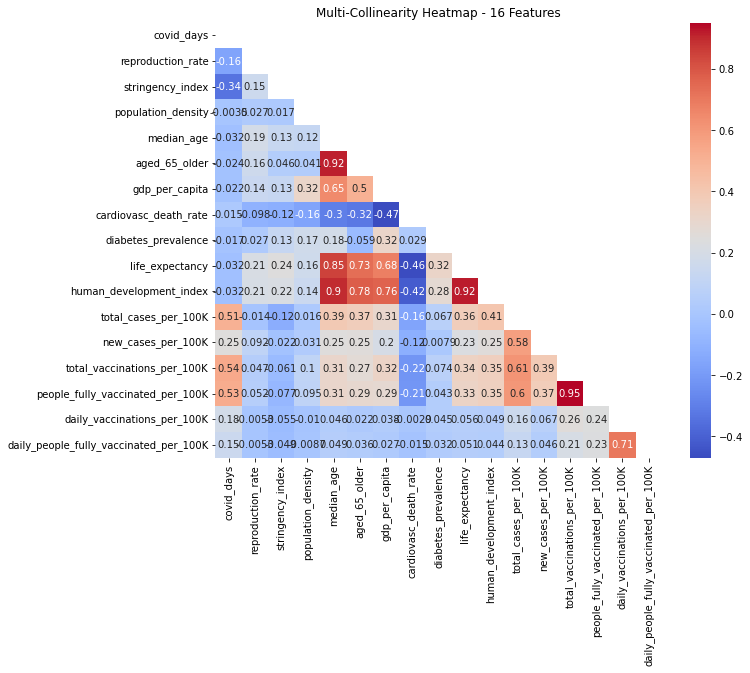

In [26]:
# Visualize the data for collinearity 
# Generate a mask for upper traingle
mask = np.triu(np.ones_like(phase1_cases_df.corr(), dtype=bool))
plt.figure(figsize=(10, 8))
sns.heatmap(phase1_cases_df.corr(), annot=True, mask=mask, cmap='coolwarm')
plt.title('Multi-Collinearity Heatmap - 16 Features')
plt.show()

- If high multicollinearity exists for the control variables but not the experimental variables, then you can interpret the experimental variables without problems.
- Multicollinearity affects the coefficients and p-values, but it does not influence the predictions, precision of the predictions, and the goodness-of-fit statistics. If your primary goal is to make predictions, and you don’t need to understand the role of each independent variable, you don’t need to reduce severe multicollinearity.
- If must resolve multicollinearity, here are some solutions: 
    1. Remove some of the highly correlated independent variables.
    2. Perform an analysis designed for highly correlated variables, such as principal components analysis or partial least squares regression.

- Variables such as **total_vaccinations_per_100K** & **people_fully_vaccinated_per_100K**, **life_expectancy** & **human_development_index**, **median_age** & **human_development_index**, **median_age** & **aged_65_older**, and **median_age** & **life_expectancy** are having a very strong positive correlation.
- To a lesser degree, variables such as **aged_65_older** & **human_development_index**, **gdp_per_capita** & **human_development_index**, and **aged_65_older**, & **life_expectancy** are also having a strong positive correlation. 
- **Generally speaking, a Pearson correlation coefficient value greater than 0.7 indicates the presence of multi-collinearity.**

Consider dropping one of the following corelated columns: **total_vaccinations_per_100K, people_fully_vaccinated_per_100K**. 

Consider dropping one of the following corelated columns: **life_expectancy, human_development_index**. 

Consider dropping one of the following corelated columns: **median_age, aged_65_older**. 

### Creating Regression Deep Learning Neural Network  

In [27]:
# Define Target variable
y = phase1_cases_df.new_cases_per_100K
# Define features 
X = phase1_cases_df.drop(["new_cases_per_100K"], axis=1)

In [28]:
# Show statistical description of features
X.describe()

,covid_days,reproduction_rate,stringency_index,population_density,median_age,aged_65_older,gdp_per_capita,cardiovasc_death_rate,diabetes_prevalence,life_expectancy,human_development_index,total_cases_per_100K,total_vaccinations_per_100K,people_fully_vaccinated_per_100K,daily_vaccinations_per_100K,daily_people_fully_vaccinated_per_100K
count,99856.000000,99856.000000,99856.000000,99856.000000,99856.000000,99856.000000,99856.000000,99856.000000,99856.000000,99856.000000,99856.000000,99856.000000,99856.000000,99856.000000,99856.000000,99856.000000
mean,441.474684,1.008028,54.819652,202.876759,30.594998,8.984831,18818.183709,259.332345,7.297077,72.677470,0.724299,3015.599002,24451.818419,9825.939553,2467.820411,738.613575
std,210.038228,0.357605,21.415210,711.345766,9.389906,6.497550,19377.210064,121.985397,3.724317,7.687053,0.156740,5337.477175,51685.157853,21449.939494,15999.340326,5888.022715
min,22.000000,-0.030000,0.000000,1.980000,15.100000,1.144000,661.240000,79.370000,0.990000,53.280000,0.394000,0.008100,0.000000,0.000000,0.000000,0.000000
25%,261.000000,0.820000,42.130000,35.608000,21.500000,3.244000,3689.251000,156.139000,4.820000,66.600000,0.584000,86.101175,0.000000,0.000000,0.000000,0.000000
50%,433.000000,1.000000,55.560000,80.080000,29.700000,6.378000,12294.876000,245.465000,6.820000,74.480000,0.750000,519.389600,0.000000,0.000000,0.000000,0.000000
75%,621.000000,1.180000,71.300000,145.725000,39.600000,14.799000,27216.445000,329.635000,8.520000,77.970000,0.852000,3883.896600,10410.000000,1980.000000,112.509983,13.257681
max,817.000000,5.820000,100.000000,7915.731000,48.200000,27.049000,116935.600000,724.417000,22.020000,84.630000,0.957000,52395.953300,263560.000000,95130.000000,242017.647136,95132.099293


Standardize numerical variables using Scikit-Learn's StandardScaler class. <br>
We must split our data into the training and testing sets prior to standardization to not incorporate the testing values into the scale.

In [29]:
# Split the data into training and testing datasets.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [30]:
# Check the shapes of training/ testing datasets.
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (74892, 16)
X_test shape: (24964, 16)
y_train shape: (74892,)
y_test shape: (24964,)


In [ ]:
# y_train=np.reshape(y_train, (-1,1))
# y_test=np.reshape(y_test, (-1,1))

In [31]:
# Create a StandardScaler instance 
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [32]:
# Check the scaled data
X_train_scaled

array([[-0.57105937,  0.36975004, -0.3105722 , ..., -0.45781868,
        -0.15382825, -0.12536871],
       [-0.51874383,  0.00620229,  1.50538332, ..., -0.45781868,
        -0.15382825, -0.12536871],
       [-0.77080959,  0.28585441, -0.00799077, ..., -0.45781868,
        -0.15382825, -0.12536871],
       ...,
       [ 0.05672705,  0.00620229,  0.29459066, ..., -0.45781868,
        -0.15382825, -0.12536871],
       [-0.26667808,  0.17399356,  0.3380167 , ..., -0.45781868,
        -0.15382825, -0.12536871],
       [ 1.69277648, -2.51066674, -1.43497974, ..., -0.45781868,
        -0.15382825, -0.12536871]])

# Deep Learning Neural Network

In [33]:
# Define the model - deep neural net

# Define the input and hidden layers.
number_input_features = len(X_train_scaled[0])
hidden_nodes_layer1 = 8
hidden_nodes_layer2 = 5

# Generate a new Sequential model.
nn_16 = tf.keras.models.Sequential()

# Add the input and first hidden layer.
nn_16.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, 
                             input_dim=number_input_features, 
                             activation="relu"))
# Add second hiddern layer.
nn_16.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, 
                             activation="relu"))
# Output layer.
nn_16.add(tf.keras.layers.Dense(units=1, activation="relu"))

# Check the structure of the model.
nn_16.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 136       
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 45        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6         
Total params: 187
Trainable params: 187
Non-trainable params: 0
_________________________________________________________________


In [34]:
# Import checkpoint dependencies
import os
from tensorflow.keras.callbacks import ModelCheckpoint

In [35]:
# Define the checkpoint path and filenames
os.makedirs("./Neural_Networks/checkpoints_16_basic/", exist_ok=True)
checkpoint_16_path = "./Neural_Networks/checkpoints_16_basic/weights.{epoch:02d}.hdf5"

In [36]:
# Compile the model.
nn_16.compile(loss="mse", optimizer="adam", metrics=['mae'])

In [37]:
# Create a callback that saves the model's weights every epoch
cp_callback = ModelCheckpoint(
    filepath = checkpoint_16_path,
    verbose=1,
    save_weights_only=True,
    save_freq='epoch')

#### Train & Evaluate

In [38]:
# Train the model. shuffle=True?
fit_16_model = nn_16.fit(X_train_scaled, y_train, epochs=100,  validation_split=0.2, shuffle=True, callbacks=[cp_callback])

Epoch 1/100
1856/1873 [============================>.] - ETA: 0s - loss: 2087.4419 - mae: 15.5709- ETA: 0s - loss: 2590.
Epoch 00001: saving model to checkpoints_16_basic\weights.01.hdf5
1873/1873 [==============================] - 2s 1ms/step - loss: 2088.2905 - mae: 15.5629 - val_loss: 1842.8394 - val_mae: 14.2519
Epoch 2/100
1871/1873 [============================>.] - ETA: 0s - loss: 1643.0342 - mae: 14.3644- ETA: 1s - lo
Epoch 00002: saving model to checkpoints_16_basic\weights.02.hdf5
1873/1873 [==============================] - 2s 1ms/step - loss: 1642.2980 - mae: 14.3631 - val_loss: 1703.8622 - val_mae: 13.5215
Epoch 3/100
1870/1873 [============================>.] - ETA: 0s - loss: 1573.6427 - mae: 13.7760
Epoch 00003: saving model to checkpoints_16_basic\weights.03.hdf5
1873/1873 [==============================] - 2s 1ms/step - loss: 1572.4631 - mae: 13.7728 - val_loss: 1681.8361 - val_mae: 13.4566
Epoch 4/100
1868/1873 [============================>.] - ETA: 0s - loss: 1550.

Epoch 28/100
1869/1873 [============================>.] - ETA: 0s - loss: 1252.2769 - mae: 11.6966
Epoch 00028: saving model to checkpoints_16_basic\weights.28.hdf5
1873/1873 [==============================] - 2s 1ms/step - loss: 1251.4517 - mae: 11.6945 - val_loss: 1409.3911 - val_mae: 11.5947
Epoch 29/100
1870/1873 [============================>.] - ETA: 0s - loss: 1247.2026 - mae: 11.6900- ETA:
Epoch 00029: saving model to checkpoints_16_basic\weights.29.hdf5
1873/1873 [==============================] - 3s 1ms/step - loss: 1246.4445 - mae: 11.6867 - val_loss: 1409.8015 - val_mae: 11.5889
Epoch 30/100
1834/1873 [============================>.] - ETA: 0s - loss: 1241.5741 - mae: 11.6535
Epoch 00030: saving model to checkpoints_16_basic\weights.30.hdf5
1873/1873 [==============================] - 2s 1ms/step - loss: 1242.7581 - mae: 11.6614 - val_loss: 1400.4431 - val_mae: 11.5269
Epoch 31/100
1852/1873 [============================>.] - ETA: 0s - loss: 1226.4219 - mae: 11.6156
Epoch 0

1854/1873 [============================>.] - ETA: 0s - loss: 1188.7258 - mae: 11.4181- ETA: 0s - loss: 1198.3285
Epoch 00055: saving model to checkpoints_16_basic\weights.55.hdf5
1873/1873 [==============================] - 2s 1ms/step - loss: 1185.8646 - mae: 11.4180 - val_loss: 1362.6481 - val_mae: 11.3521
Epoch 56/100
1836/1873 [============================>.] - ETA: 0s - loss: 1199.7493 - mae: 11.4843
Epoch 00056: saving model to checkpoints_16_basic\weights.56.hdf5
1873/1873 [==============================] - 2s 1ms/step - loss: 1184.8364 - mae: 11.4358 - val_loss: 1358.7427 - val_mae: 11.1836
Epoch 57/100
1872/1873 [============================>.] - ETA: 0s - loss: 1184.4271 - mae: 11.4270
Epoch 00057: saving model to checkpoints_16_basic\weights.57.hdf5
1873/1873 [==============================] - 2s 1ms/step - loss: 1184.2588 - mae: 11.4260 - val_loss: 1362.5482 - val_mae: 11.3290
Epoch 58/100
1855/1873 [============================>.] - ETA: 0s - loss: 1183.1606 - mae: 11.4041

1871/1873 [============================>.] - ETA: 0s - loss: 1138.1812 - mae: 11.3198
Epoch 00082: saving model to checkpoints_16_basic\weights.82.hdf5
1873/1873 [==============================] - 2s 1ms/step - loss: 1137.4866 - mae: 11.3163 - val_loss: 1317.4662 - val_mae: 11.2793
Epoch 83/100
1838/1873 [============================>.] - ETA: 0s - loss: 1135.2921 - mae: 11.3414
Epoch 00083: saving model to checkpoints_16_basic\weights.83.hdf5
1873/1873 [==============================] - 2s 1ms/step - loss: 1136.3772 - mae: 11.3419 - val_loss: 1323.1094 - val_mae: 11.2517
Epoch 84/100
1868/1873 [============================>.] - ETA: 0s - loss: 1135.3680 - mae: 11.3264
Epoch 00084: saving model to checkpoints_16_basic\weights.84.hdf5
1873/1873 [==============================] - 2s 1ms/step - loss: 1135.0308 - mae: 11.3276 - val_loss: 1362.4935 - val_mae: 11.5342
Epoch 85/100
1863/1873 [============================>.] - ETA: 0s - loss: 1136.2233 - mae: 11.3044
Epoch 00085: saving model 

In [39]:
# Create a DataFrame containing multi-neuron training history. 
nn_16_history_df = pd.DataFrame(fit_16_model.history, index=range(1, len(fit_16_model.history["loss"])+1))
nn_16_history_df.head()

,loss,mae,val_loss,val_mae
1,2088.290527,15.562870,1842.839355,14.251914
2,1642.297974,14.363093,1703.862183,13.521502
3,1572.463135,13.772779,1681.836060,13.456577
4,1548.438843,13.580263,1655.439697,12.872547
5,1527.988281,13.389603,1638.552368,12.873437


<function matplotlib.pyplot.show(close=None, block=None)>

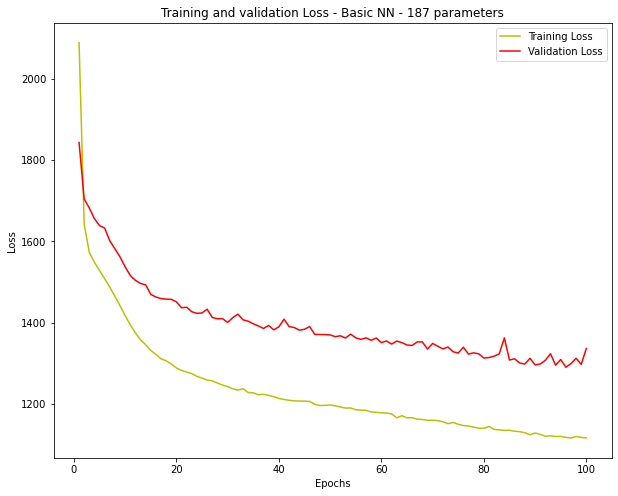

In [78]:
# Plot the training and validation accuracy and loss at each epoch
loss = fit_16_model.history['loss']
val_loss = fit_16_model.history['val_loss']
epochs= range(1, len(loss) + 1)
plt.figure(figsize=(10, 8))
plt.plot(epochs, loss, 'y', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation Loss - Basic NN - 187 parameters')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show

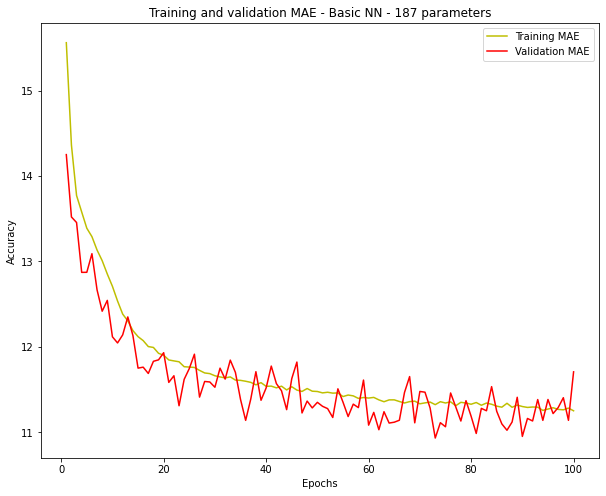

In [79]:
acc = fit_16_model.history['mae']
val_acc = fit_16_model.history['val_mae']
plt.figure(figsize=(10, 8))
plt.plot(epochs, acc, 'y', label='Training MAE')
plt.plot(epochs, val_acc, 'r', label='Validation MAE')
plt.title('Training and Validation MAE')
plt.title('Training and validation MAE - Basic NN - 187 parameters')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [42]:
# Predict on test data
predictions_nn16 = nn_16.predict(X_test_scaled[:5])
print("Predicted values are: ", predictions_nn16)
print("Real values are: ", y_test[:5])

Predicted values are:  [[120.98579  ]
 [  5.951979 ]
 [  0.       ]
 [ 70.55575  ]
 [  1.9218242]]
Real values are:  id_row
55668     54.7092
127576     0.0000
125221     0.9099
36631     36.8305
197650     4.9681
Name: new_cases_per_100K, dtype: float64


In [85]:
# Neural Network evaluation
mse_neural, mae_neural = nn_16.evaluate(X_test_scaled, y_test)
print("Mean squared error from neural net: ", mse_neural)
print("Mean absolute error from neural net: ", mae_neural)

781/781 [==============================] - 0s 554us/step - loss: 1145.8032 - mae: 11.7824
Mean squared error from neural net:  1145.80322265625
Mean absolute error from neural net:  11.782356262207031


In [61]:
# # Create a new dataframe with actual and predictions values
# # # Scale the whole data SCALED
# X_scaled = X_scaler.transform(X)
# nn_16_predictions = nn_16.predict(X_scaled)
# predictions16_df = pd.DataFrame({"Actual": y, "Predicted": nn_16_predictions, "residuals": nn_16_predictions - y})[["Actual", "Predicted", "residuals"]]
# predictions16_df.head(5)

MemoryError: Unable to allocate 74.3 GiB for an array with shape (99856, 99856) and data type float64

### Deep Learning Neural Network Enhancement

### Increase Nodes and Epochs on 16 Features

2x to 3x the number of inputs

In [49]:
# Define the model - deep neural net

# Define the input and hidden layers.
number_input_features = len(X_train_scaled[0])
hidden_nodes_layer1 = 48
hidden_nodes_layer2 = 32

# Generate a new Sequential model.
nn_16_optimized = tf.keras.models.Sequential()

# Add the input and first hidden layer.
nn_16_optimized.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, 
                             input_dim=number_input_features, 
                             activation="relu"))
# Add second hiddern layer.
nn_16_optimized.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, 
                             activation="relu"))
# Output layer.
nn_16_optimized.add(tf.keras.layers.Dense(units=1, activation="relu"))

# Check the structure of the model.
nn_16_optimized.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 48)                816       
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1568      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 2,417
Trainable params: 2,417
Non-trainable params: 0
_________________________________________________________________


In [50]:
# Define the checkpoint path and filenames
os.makedirs("./Neural_Networks/checkpoints_16_optimized/", exist_ok=True)
checkpoint_16_optimized_path = "./Neural_Networks/checkpoints_16_optimized/weights.{epoch:02d}.hdf5"

In [51]:
# Compile the model.
nn_16_optimized.compile(loss="mse", optimizer="adam", metrics=['mae'])

In [52]:
# Create a callback that saves the model's weights every epoch
cp_callback = ModelCheckpoint(
    filepath = checkpoint_16_optimized_path,
    verbose=1,
    save_weights_only=True,
    save_freq='epoch')

In [53]:
# Train the model. shuffle=True?
fit_nn_16_optimized = nn_16_optimized.fit(X_train_scaled, y_train, epochs=100,  validation_split=0.2, shuffle=True, callbacks=[cp_callback])

Epoch 1/100
1828/1873 [============================>.] - ETA: 0s - loss: 1724.5322 - mae: 14.0647- ETA: 1s - loss: 2043.9570 - ETA: 0s - loss: 1909.0009 - mae - ETA: 0s - loss: 1784.5786 - mae: 14.2
Epoch 00001: saving model to checkpoints_16_optimized\weights.01.hdf5
1873/1873 [==============================] - 2s 1ms/step - loss: 1714.9050 - mae: 14.0431 - val_loss: 1625.6730 - val_mae: 12.4725
Epoch 2/100
1846/1873 [============================>.] - ETA: 0s - loss: 1463.2648 - mae: 12.6056
Epoch 00002: saving model to checkpoints_16_optimized\weights.02.hdf5
1873/1873 [==============================] - 2s 1ms/step - loss: 1458.7544 - mae: 12.5969 - val_loss: 1547.5212 - val_mae: 11.8624
Epoch 3/100
1854/1873 [============================>.] - ETA: 0s - loss: 1407.8033 - mae: 12.4005
Epoch 00003: saving model to checkpoints_16_optimized\weights.03.hdf5
1873/1873 [==============================] - 2s 1ms/step - loss: 1400.5436 - mae: 12.3681 - val_loss: 1502.9908 - val_mae: 11.5461
Ep

Epoch 28/100
1841/1873 [============================>.] - ETA: 0s - loss: 1071.6655 - mae: 10.5069
Epoch 00028: saving model to checkpoints_16_optimized\weights.28.hdf5
1873/1873 [==============================] - 2s 1ms/step - loss: 1077.5088 - mae: 10.5218 - val_loss: 1237.4586 - val_mae: 10.8914
Epoch 29/100
1825/1873 [============================>.] - ETA: 0s - loss: 1074.6448 - mae: 10.5021- ETA: 1s
Epoch 00029: saving model to checkpoints_16_optimized\weights.29.hdf5
1873/1873 [==============================] - 2s 1ms/step - loss: 1078.3530 - mae: 10.5226 - val_loss: 1277.2817 - val_mae: 10.5257
Epoch 30/100
1842/1873 [============================>.] - ETA: 0s - loss: 1052.7521 - mae: 10.3867
Epoch 00030: saving model to checkpoints_16_optimized\weights.30.hdf5
1873/1873 [==============================] - 2s 1ms/step - loss: 1058.7634 - mae: 10.4122 - val_loss: 1217.3368 - val_mae: 10.4083
Epoch 31/100
1843/1873 [============================>.] - ETA: 0s - loss: 1060.6361 - mae: 

1843/1873 [============================>.] - ETA: 0s - loss: 909.2888 - mae: 9.9012
Epoch 00055: saving model to checkpoints_16_optimized\weights.55.hdf5
1873/1873 [==============================] - 2s 1ms/step - loss: 904.4020 - mae: 9.8950 - val_loss: 1063.4032 - val_mae: 9.8157
Epoch 56/100
1840/1873 [============================>.] - ETA: 0s - loss: 902.7292 - mae: 9.8481- ETA: 0s - loss: 813.1687
Epoch 00056: saving model to checkpoints_16_optimized\weights.56.hdf5
1873/1873 [==============================] - 2s 1ms/step - loss: 898.2642 - mae: 9.8434 - val_loss: 1036.6106 - val_mae: 9.5348
Epoch 57/100
1860/1873 [============================>.] - ETA: 0s - loss: 907.2202 - mae: 9.8336- ETA: 0s - loss: 910.8549 - mae: 9.8
Epoch 00057: saving model to checkpoints_16_optimized\weights.57.hdf5
1873/1873 [==============================] - 2s 1ms/step - loss: 903.6251 - mae: 9.8233 - val_loss: 1088.0209 - val_mae: 9.5842
Epoch 58/100
1848/1873 [============================>.] - ETA: 0s

1860/1873 [============================>.] - ETA: 0s - loss: 809.1932 - mae: 9.4028
Epoch 00082: saving model to checkpoints_16_optimized\weights.82.hdf5
1873/1873 [==============================] - 2s 1ms/step - loss: 808.3696 - mae: 9.3983 - val_loss: 981.1741 - val_mae: 9.2940
Epoch 83/100
1832/1873 [============================>.] - ETA: 0s - loss: 801.2576 - mae: 9.3749
Epoch 00083: saving model to checkpoints_16_optimized\weights.83.hdf5
1873/1873 [==============================] - 2s 1ms/step - loss: 796.2034 - mae: 9.3604 - val_loss: 961.2194 - val_mae: 9.3676
Epoch 84/100
1857/1873 [============================>.] - ETA: 0s - loss: 799.0270 - mae: 9.3604
Epoch 00084: saving model to checkpoints_16_optimized\weights.84.hdf5
1873/1873 [==============================] - 2s 1ms/step - loss: 797.8501 - mae: 9.3531 - val_loss: 950.6004 - val_mae: 9.1925
Epoch 85/100
1863/1873 [============================>.] - ETA: 0s - loss: 787.9866 - mae: 9.3536
Epoch 00085: saving model to check

In [54]:
# Create a DataFrame containing multi-neuron training history. 
nn_16_optimized_df = pd.DataFrame(fit_nn_16_optimized.history, index=range(1, len(fit_16_model.history["loss"])+1))
nn_16_optimized_df.head()

,loss,mae,val_loss,val_mae
1,1714.905029,14.043122,1625.672974,12.472486
2,1458.754395,12.596890,1547.521240,11.862354
3,1400.543579,12.368106,1502.990845,11.546118
4,1364.858643,12.165725,1527.039429,12.441533
5,1337.632324,12.033606,1455.360840,11.646982


<function matplotlib.pyplot.show(close=None, block=None)>

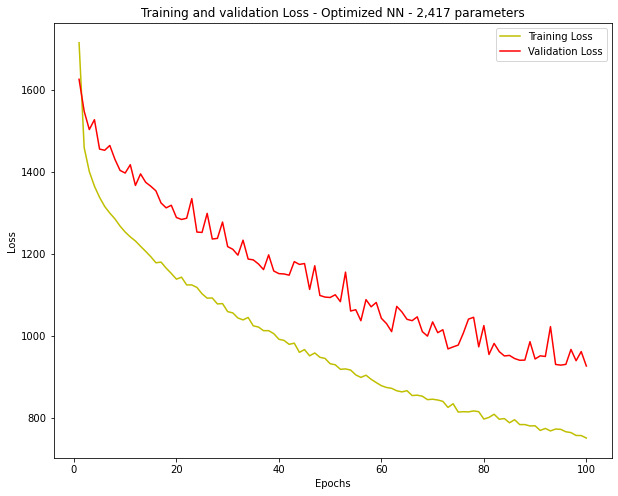

In [86]:
# Plot the training and validation accuracy and loss at each epoch
loss = fit_nn_16_optimized.history['loss']
val_loss = fit_nn_16_optimized.history['val_loss']
epochs= range(1, len(loss) + 1)
plt.figure(figsize=(10, 8))
plt.plot(epochs, loss, 'y', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation Loss - Optimized NN - 2,417 parameters')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show

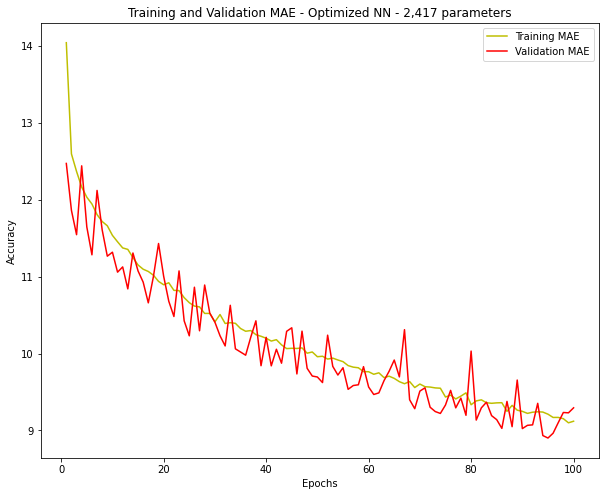

In [88]:
acc = fit_nn_16_optimized.history['mae']
val_acc = fit_nn_16_optimized.history['val_mae']
plt.figure(figsize=(10, 8))
plt.plot(epochs, acc, 'y', label='Training MAE')
plt.plot(epochs, val_acc, 'r', label='Validation MAE')
plt.title('Training and Validation MAE - Optimized NN - 2,417 parameters')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [57]:
# Neural Network evaluation
mse_neural, mae_neural = nn_16_optimized.evaluate(X_test_scaled, y_test)
print("Mean squared error from neural net: ", mse_neural)
print("Mean absolute error from neural net: ", mae_neural)

781/781 [==============================] - 1s 848us/step - loss: 740.0748 - mae: 9.4086
Mean squared error from neural net:  740.0748291015625
Mean absolute error from neural net:  9.408642768859863


In [58]:
# Predict on test data
pred_nn16_optimized = nn_16_optimized.predict(X_test_scaled[:5])
print("Predicted values are: ", pred_nn16_optimized)
print("Real values are: ", y_test[:5])

Predicted values are:  [[93.55949  ]
 [ 0.       ]
 [ 3.6459322]
 [31.107399 ]
 [ 0.       ]]
Real values are:  id_row
55668     54.7092
127576     0.0000
125221     0.9099
36631     36.8305
197650     4.9681
Name: new_cases_per_100K, dtype: float64


In [60]:
# # Create a new dataframe with actual and predictions values
# # # Scale the whole data SCALED
# X_scaled = X_scaler.transform(X)
# nn_16_pred_optimized = nn_16_optimized.predict(X_scaled)
# pred_16_optimized_df = pd.DataFrame({"Actual": y, "Predicted": nn_16_pred_optimized, "Residuals": nn_16_pred_optimized - y})[["Actual", "Predicted", "Residuals"]]
# pred_16_optimized_df.head(5)

MemoryError: Unable to allocate 74.3 GiB for an array with shape (99856, 99856) and data type float64

### Increasing Neurons in Hidden Layers and Training Epochs

In [62]:
# Define the model - deep neural net

# Define the input and hidden layers.
number_input_features = len(X_train_scaled[0])
hidden_nodes_layer1 = 128
hidden_nodes_layer2 = 64

# Generate a new Sequential model.
nn_16_enhanced = tf.keras.models.Sequential()

# Add the input and first hidden layer.
nn_16_enhanced.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, 
                             input_dim=number_input_features, 
                             activation="relu"))
# Add second hiddern layer.
nn_16_enhanced.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, 
                             activation="relu"))
# Output layer.
nn_16_enhanced.add(tf.keras.layers.Dense(units=1, activation="relu"))

# Check the structure of the model.
nn_16_enhanced.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 128)               2176      
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 10,497
Trainable params: 10,497
Non-trainable params: 0
_________________________________________________________________


In [65]:
# Define the checkpoint path and filenames
os.makedirs("./Neural_Networks/checkpoints_16_enhanced/", exist_ok=True)
checkpoint_16_enhanced_path = "./Neural_Networks/checkpoints_16_enhanced/weights.{epoch:02d}.hdf5"

In [66]:
# Compile the model.
nn_16_enhanced.compile(loss="mse", optimizer="adam", metrics=['mae'])

In [67]:
# Create a callback that saves the model's weights every epoch
cp_callback = ModelCheckpoint(
    filepath = checkpoint_16_enhanced_path,
    verbose=1,
    save_weights_only=True,
    save_freq='epoch')

#### Train & Evaluate

In [68]:
# Train the model. shuffle=True?
fit_16_enhanced_model = nn_16_enhanced.fit(X_train_scaled, y_train, epochs=150,  validation_split=0.2, shuffle=True, callbacks=[cp_callback])

Epoch 1/150
1812/1873 [============================>.] - ETA: 0s - loss: 1669.2518 - mae: 13.9045
Epoch 00001: saving model to checkpoints_16_enhanced\weights.01.hdf5
1873/1873 [==============================] - 2s 980us/step - loss: 1649.1853 - mae: 13.8416 - val_loss: 1651.9757 - val_mae: 11.6240
Epoch 2/150
1849/1873 [============================>.] - ETA: 0s - loss: 1405.3806 - mae: 12.3179
Epoch 00002: saving model to checkpoints_16_enhanced\weights.02.hdf5
1873/1873 [==============================] - 2s 1ms/step - loss: 1407.0911 - mae: 12.3216 - val_loss: 1493.0811 - val_mae: 11.5825
Epoch 3/150
1828/1873 [============================>.] - ETA: 0s - loss: 1245.8622 - mae: 11.8929
Epoch 00003: saving model to checkpoints_16_enhanced\weights.03.hdf5
1873/1873 [==============================] - 2s 1ms/step - loss: 1334.9359 - mae: 11.9185 - val_loss: 1533.7191 - val_mae: 12.7141
Epoch 4/150
1826/1873 [============================>.] - ETA: 0s - loss: 1316.4089 - mae: 11.7370
Epoch 

Epoch 28/150
1872/1873 [============================>.] - ETA: 0s - loss: 916.9433 - mae: 9.6087
Epoch 00028: saving model to checkpoints_16_enhanced\weights.28.hdf5
1873/1873 [==============================] - 1s 799us/step - loss: 916.9402 - mae: 9.6091 - val_loss: 1100.7174 - val_mae: 9.4698
Epoch 29/150
1812/1873 [============================>.] - ETA: 0s - loss: 901.8378 - mae: 9.5744
Epoch 00029: saving model to checkpoints_16_enhanced\weights.29.hdf5
1873/1873 [==============================] - 1s 792us/step - loss: 908.8463 - mae: 9.5849 - val_loss: 1052.3950 - val_mae: 9.2088
Epoch 30/150
1870/1873 [============================>.] - ETA: 0s - loss: 888.1161 - mae: 9.4198
Epoch 00030: saving model to checkpoints_16_enhanced\weights.30.hdf5
1873/1873 [==============================] - 2s 858us/step - loss: 887.4578 - mae: 9.4166 - val_loss: 1064.4969 - val_mae: 9.0943
Epoch 31/150
1825/1873 [============================>.] - ETA: 0s - loss: 883.2352 - mae: 9.3972- ETA: 0s - loss

1829/1873 [============================>.] - ETA: 0s - loss: 723.2127 - mae: 8.5378
Epoch 00055: saving model to checkpoints_16_enhanced\weights.55.hdf5
1873/1873 [==============================] - 2s 913us/step - loss: 724.1454 - mae: 8.5441 - val_loss: 998.2790 - val_mae: 9.2301
Epoch 56/150
1843/1873 [============================>.] - ETA: 0s - loss: 726.5377 - mae: 8.5134
Epoch 00056: saving model to checkpoints_16_enhanced\weights.56.hdf5
1873/1873 [==============================] - 2s 877us/step - loss: 724.5975 - mae: 8.5237 - val_loss: 932.4163 - val_mae: 8.4522
Epoch 57/150
1798/1873 [===========================>..] - ETA: 0s - loss: 731.4921 - mae: 8.5177
Epoch 00057: saving model to checkpoints_16_enhanced\weights.57.hdf5
1873/1873 [==============================] - 2s 824us/step - loss: 724.3489 - mae: 8.5037 - val_loss: 915.9543 - val_mae: 8.4965
Epoch 58/150
1862/1873 [============================>.] - ETA: 0s - loss: 720.4536 - mae: 8.5405
Epoch 00058: saving model to ch

Epoch 83/150
1808/1873 [===========================>..] - ETA: 0s - loss: 655.7391 - mae: 8.0769
Epoch 00083: saving model to checkpoints_16_enhanced\weights.83.hdf5
1873/1873 [==============================] - 2s 847us/step - loss: 654.2835 - mae: 8.0861 - val_loss: 887.9633 - val_mae: 8.5541
Epoch 84/150
1833/1873 [============================>.] - ETA: 0s - loss: 653.8726 - mae: 8.0813
Epoch 00084: saving model to checkpoints_16_enhanced\weights.84.hdf5
1873/1873 [==============================] - 1s 788us/step - loss: 650.6254 - mae: 8.0764 - val_loss: 833.0128 - val_mae: 7.7673
Epoch 85/150
1863/1873 [============================>.] - ETA: 0s - loss: 638.4958 - mae: 8.0610
Epoch 00085: saving model to checkpoints_16_enhanced\weights.85.hdf5
1873/1873 [==============================] - 2s 858us/step - loss: 636.1235 - mae: 8.0501 - val_loss: 862.4510 - val_mae: 8.1295
Epoch 86/150
1853/1873 [============================>.] - ETA: 0s - loss: 639.3517 - mae: 7.9626
Epoch 00086: savin

1836/1873 [============================>.] - ETA: 0s - loss: 604.6506 - mae: 7.6935- ETA: 0s - loss: 591.7788 - mae: 7.636
Epoch 00110: saving model to checkpoints_16_enhanced\weights.110.hdf5
1873/1873 [==============================] - 2s 924us/step - loss: 599.1152 - mae: 7.6858 - val_loss: 861.4391 - val_mae: 7.9082
Epoch 111/150
1866/1873 [============================>.] - ETA: 0s - loss: 593.4239 - mae: 7.6525
Epoch 00111: saving model to checkpoints_16_enhanced\weights.111.hdf5
1873/1873 [==============================] - 2s 934us/step - loss: 591.9459 - mae: 7.6468 - val_loss: 815.6161 - val_mae: 7.7536
Epoch 112/150
1797/1873 [===========================>..] - ETA: 0s - loss: 498.6737 - mae: 7.5138
Epoch 00112: saving model to checkpoints_16_enhanced\weights.112.hdf5
1873/1873 [==============================] - 2s 894us/step - loss: 587.8482 - mae: 7.5831 - val_loss: 990.6590 - val_mae: 9.7051
Epoch 113/150
1861/1873 [============================>.] - ETA: 0s - loss: 601.6329 

1857/1873 [============================>.] - ETA: 0s - loss: 571.0765 - mae: 7.4513
Epoch 00137: saving model to checkpoints_16_enhanced\weights.137.hdf5
1873/1873 [==============================] - 2s 865us/step - loss: 569.1968 - mae: 7.4486 - val_loss: 844.4249 - val_mae: 7.8734
Epoch 138/150
1869/1873 [============================>.] - ETA: 0s - loss: 571.5110 - mae: 7.5251
Epoch 00138: saving model to checkpoints_16_enhanced\weights.138.hdf5
1873/1873 [==============================] - 2s 857us/step - loss: 571.3447 - mae: 7.5282 - val_loss: 851.6951 - val_mae: 7.9144
Epoch 139/150
1804/1873 [===========================>..] - ETA: 0s - loss: 563.8749 - mae: 7.4427
Epoch 00139: saving model to checkpoints_16_enhanced\weights.139.hdf5
1873/1873 [==============================] - 2s 879us/step - loss: 564.1260 - mae: 7.4575 - val_loss: 830.2307 - val_mae: 7.8664
Epoch 140/150
1859/1873 [============================>.] - ETA: 0s - loss: 566.4623 - mae: 7.4062
Epoch 00140: saving model

In [69]:
# Create a DataFrame containing multi-neuron training history. 
nn_16_enhanced_history_df = pd.DataFrame(fit_16_enhanced_model.history, index=range(1, len(fit_16_enhanced_model.history["loss"])+1))
nn_16_enhanced_history_df.head()

,loss,mae,val_loss,val_mae
1,1649.185303,13.841630,1651.975708,11.624035
2,1407.091064,12.321630,1493.081055,11.582486
3,1334.935913,11.918482,1533.719116,12.714116
4,1307.659790,11.708208,1458.231567,10.998481
5,1283.617676,11.522228,1418.687134,11.164212


<function matplotlib.pyplot.show(close=None, block=None)>

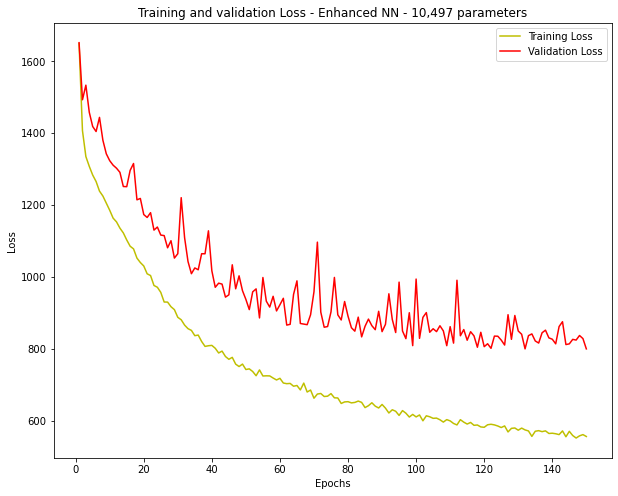

In [89]:
# Plot the training and validation accuracy and loss at each epoch
loss = fit_16_enhanced_model.history['loss']
val_loss = fit_16_enhanced_model.history['val_loss']
epochs= range(1, len(loss) + 1)
plt.figure(figsize=(10, 8))
plt.plot(epochs, loss, 'y', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation Loss - Enhanced NN - 10,497 parameters')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show

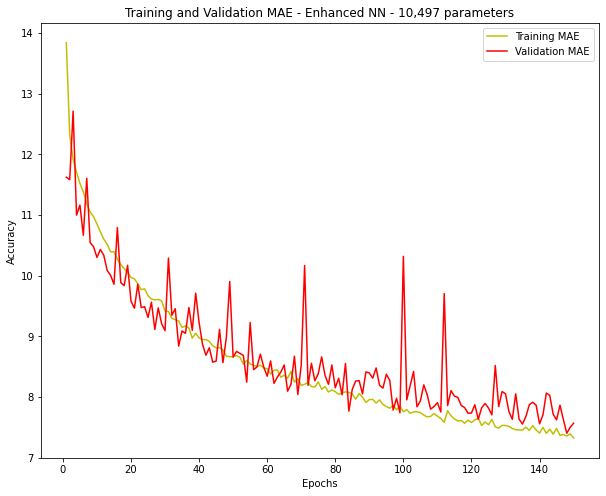

In [90]:
acc = fit_16_enhanced_model.history['mae']
val_acc = fit_16_enhanced_model.history['val_mae']
plt.figure(figsize=(10, 8))
plt.plot(epochs, acc, 'y', label='Training MAE')
plt.plot(epochs, val_acc, 'r', label='Validation MAE')
plt.title('Training and Validation MAE - Enhanced NN - 10,497 parameters')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [72]:
# Predict on test data
pred_nn16_enhanced = nn_16_enhanced.predict(X_test_scaled[:5])
print("Predicted values are: ", pred_nn16_enhanced)
print("Real values are: ", y_test[:5])

Predicted values are:  [[79.926   ]
 [ 0.      ]
 [ 0.      ]
 [31.610085]
 [ 0.      ]]
Real values are:  id_row
55668     54.7092
127576     0.0000
125221     0.9099
36631     36.8305
197650     4.9681
Name: new_cases_per_100K, dtype: float64


In [73]:
# Neural Network evaluation
mse_neural, mae_neural = nn_16_enhanced.evaluate(X_test_scaled, y_test)
print("Mean squared error from neural net: ", mse_neural)
print("Mean absolute error from neural net: ", mae_neural)

781/781 [==============================] - 0s 637us/step - loss: 622.7482 - mae: 7.6989
Mean squared error from neural net:  622.7482299804688
Mean absolute error from neural net:  7.698912143707275


In [75]:
# # Create a new dataframe with actual and predictions values
# # # Scale the whole data SCALED
# # X_scaled = X_scaler.transform(X)
# nn_16_pred_enhanced = nn_16_enhanced.predict(X_scaled)
# pred_16_enhanced_df = pd.DataFrame({"Actual": y, "Predicted": nn_16_pred_enhanced, "Residuals": nn_16_pred_enhanced - y})[["Actual", "Predicted", "Residuals"]]
# pred_16_enhanced_df.head(5)

MemoryError: Unable to allocate 74.3 GiB for an array with shape (99856, 99856) and data type float64

#### Reducing Number of Features by Removine Ones with Severe Collinearity

In [92]:
# Remove Features with strong collinearity from the Random forest Regression features importance. 
# Define target column 
y1 = phase1_cases_df.new_cases_per_100K
feature_drop = ['new_cases_per_100K', 'people_fully_vaccinated_per_100K', 'human_development_index', 'median_age']
X1 = phase1_cases_df.drop(columns=feature_drop, axis=1)
print(X1.shape)
X1.head()

(99856, 13)


,covid_days,reproduction_rate,stringency_index,population_density,aged_65_older,gdp_per_capita,cardiovasc_death_rate,diabetes_prevalence,life_expectancy,total_cases_per_100K,total_vaccinations_per_100K,daily_vaccinations_per_100K,daily_people_fully_vaccinated_per_100K
id_row,,,,,,,,,,,,,
34,88,1.52,67.59,54.422,2.581,1803.987,597.029,9.59,64.83,0.2862,0.0,0.0,0.0
35,89,1.52,67.59,54.422,2.581,1803.987,597.029,9.59,64.83,0.2862,0.0,0.0,0.0
36,90,1.53,67.59,54.422,2.581,1803.987,597.029,9.59,64.83,0.4167,0.0,0.0,0.0
37,91,1.52,67.59,54.422,2.581,1803.987,597.029,9.59,64.83,0.4820,0.0,0.0,0.0
38,92,1.52,67.59,54.422,2.581,1803.987,597.029,9.59,64.83,0.5899,0.0,0.0,0.0


In [93]:
# Split the data into training and testing datasets.
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, random_state=78)

In [94]:
# Check the shapes of training/ testing datasets.
print(f"X1_train shape: {X1_train.shape}")
print(f"X1_test shape: {X1_test.shape}")
print(f"y1_train shape: {y1_train.shape}")
print(f"y1_test shape: {y1_test.shape}")

X1_train shape: (74892, 13)
X1_test shape: (24964, 13)
y1_train shape: (74892,)
y1_test shape: (24964,)


In [95]:
# Create a StandardScaler instance 
scaler = StandardScaler()

# Fit the StandardScaler
X1_scaler = scaler.fit(X1_train)

# Scale the data
X1_train_scaled = X1_scaler.transform(X1_train)
X1_test_scaled = X1_scaler.transform(X1_test)

In [96]:
# Define the model - deep neural net

# Define the input and hidden layers.
number_input_features = len(X1_train_scaled[0])
hidden_nodes_layer1 = 128
hidden_nodes_layer2 = 64

# Generate a new Sequential model.
nn_13 = tf.keras.models.Sequential()

# Add the input and first hidden layer.
nn_13.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, 
                             input_dim=number_input_features, 
                             activation="relu"))
# Add second hiddern layer.
nn_13.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, 
                             activation="relu"))
# Output layer.
nn_13.add(tf.keras.layers.Dense(units=1, activation="relu"))

# Check the structure of the model.
nn_13.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 128)               1792      
_________________________________________________________________
dense_10 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 10,113
Trainable params: 10,113
Non-trainable params: 0
_________________________________________________________________


In [97]:
len(X1_train_scaled[0])

13

In [98]:
# Define the checkpoint path and filenames
os.makedirs("./Neural_Networks/checkpoints_13/", exist_ok=True)
checkpoint_13_path = "./Neural_Networks/checkpoints_13/weights.{epoch:02d}.hdf5"

In [99]:
# Compile the model.
nn_13.compile(loss="mse", optimizer="adam", metrics=['mae'])

In [100]:
# Create a callback that saves the model's weights every epoch
cp_callback = ModelCheckpoint(
    filepath = checkpoint_13_path,
    verbose=1,
    save_weights_only=True,
    save_freq='epoch')

#### Train & Evaluate

In [101]:
# Train the model. shuffle=True?
fit_13_model = nn_13.fit(X1_train_scaled, y1_train, epochs=150, validation_split=0.2, shuffle=True, callbacks=[cp_callback])

Epoch 1/150
1847/1873 [============================>.] - ETA: 0s - loss: 1621.8876 - mae: 13.5583
Epoch 00001: saving model to checkpoints_13\weights.01.hdf5
1873/1873 [==============================] - 2s 1ms/step - loss: 1616.0293 - mae: 13.5640 - val_loss: 1590.2035 - val_mae: 12.6249
Epoch 2/150
1855/1873 [============================>.] - ETA: 0s - loss: 1394.6857 - mae: 12.2517
Epoch 00002: saving model to checkpoints_13\weights.02.hdf5
1873/1873 [==============================] - 2s 979us/step - loss: 1401.1705 - mae: 12.2865 - val_loss: 1508.8046 - val_mae: 12.2677
Epoch 3/150
1815/1873 [============================>.] - ETA: 0s - loss: 1338.6415 - mae: 11.9961
Epoch 00003: saving model to checkpoints_13\weights.03.hdf5
1873/1873 [==============================] - 2s 943us/step - loss: 1340.0582 - mae: 12.0003 - val_loss: 1478.0588 - val_mae: 11.7521
Epoch 4/150
1824/1873 [============================>.] - ETA: 0s - loss: 1308.5323 - mae: 11.7706
Epoch 00004: saving model to ch

1834/1873 [============================>.] - ETA: 0s - loss: 907.5509 - mae: 9.5535
Epoch 00029: saving model to checkpoints_13\weights.29.hdf5
1873/1873 [==============================] - 2s 922us/step - loss: 914.2947 - mae: 9.5545 - val_loss: 1057.0641 - val_mae: 9.2997
Epoch 30/150
1837/1873 [============================>.] - ETA: 0s - loss: 897.7755 - mae: 9.4618
Epoch 00030: saving model to checkpoints_13\weights.30.hdf5
1873/1873 [==============================] - 2s 944us/step - loss: 894.6861 - mae: 9.4513 - val_loss: 1041.1128 - val_mae: 9.1895
Epoch 31/150
1856/1873 [============================>.] - ETA: 0s - loss: 895.4644 - mae: 9.4765
Epoch 00031: saving model to checkpoints_13\weights.31.hdf5
1873/1873 [==============================] - 2s 979us/step - loss: 890.4359 - mae: 9.4555 - val_loss: 1209.4384 - val_mae: 10.0112
Epoch 32/150
1848/1873 [============================>.] - ETA: 0s - loss: 876.9136 - mae: 9.4119
Epoch 00032: saving model to checkpoints_13\weights.32

Epoch 58/150
1873/1873 [==============================] - ETA: 0s - loss: 730.3295 - mae: 8.5360- ETA: 0s - loss: 743.1110 - mae: 8.5
Epoch 00058: saving model to checkpoints_13\weights.58.hdf5
1873/1873 [==============================] - 2s 974us/step - loss: 730.3295 - mae: 8.5360 - val_loss: 903.5600 - val_mae: 8.4369
Epoch 59/150
1868/1873 [============================>.] - ETA: 0s - loss: 711.9715 - mae: 8.4486
Epoch 00059: saving model to checkpoints_13\weights.59.hdf5
1873/1873 [==============================] - 2s 919us/step - loss: 710.9490 - mae: 8.4444 - val_loss: 946.1912 - val_mae: 8.5898
Epoch 60/150
1807/1873 [===========================>..] - ETA: 0s - loss: 723.7819 - mae: 8.4754
Epoch 00060: saving model to checkpoints_13\weights.60.hdf5
1873/1873 [==============================] - 2s 929us/step - loss: 719.1553 - mae: 8.4624 - val_loss: 882.3724 - val_mae: 8.3341
Epoch 61/150
1856/1873 [============================>.] - ETA: 0s - loss: 712.3082 - mae: 8.4316
Epoch 00

1856/1873 [============================>.] - ETA: 0s - loss: 627.6273 - mae: 7.9088
Epoch 00086: saving model to checkpoints_13\weights.86.hdf5
1873/1873 [==============================] - 2s 941us/step - loss: 630.9471 - mae: 7.9287 - val_loss: 873.3801 - val_mae: 8.3644
Epoch 87/150
1844/1873 [============================>.] - ETA: 0s - loss: 636.3977 - mae: 7.9384
Epoch 00087: saving model to checkpoints_13\weights.87.hdf5
1873/1873 [==============================] - 2s 887us/step - loss: 635.2098 - mae: 7.9436 - val_loss: 867.1766 - val_mae: 7.9712
Epoch 88/150
1866/1873 [============================>.] - ETA: 0s - loss: 633.1967 - mae: 7.8350
Epoch 00088: saving model to checkpoints_13\weights.88.hdf5
1873/1873 [==============================] - 2s 982us/step - loss: 631.6413 - mae: 7.8293 - val_loss: 847.0015 - val_mae: 7.9061
Epoch 89/150
1830/1873 [============================>.] - ETA: 0s - loss: 629.2458 - mae: 7.8963
Epoch 00089: saving model to checkpoints_13\weights.89.hdf

1861/1873 [============================>.] - ETA: 0s - loss: 588.6526 - mae: 7.5707
Epoch 00114: saving model to checkpoints_13\weights.114.hdf5
1873/1873 [==============================] - 2s 852us/step - loss: 586.1114 - mae: 7.5634 - val_loss: 851.5119 - val_mae: 7.7513
Epoch 115/150
1832/1873 [============================>.] - ETA: 0s - loss: 579.9704 - mae: 7.5084
Epoch 00115: saving model to checkpoints_13\weights.115.hdf5
1873/1873 [==============================] - 2s 886us/step - loss: 580.5366 - mae: 7.5128 - val_loss: 882.3421 - val_mae: 8.2094
Epoch 116/150
1864/1873 [============================>.] - ETA: 0s - loss: 581.3173 - mae: 7.5217
Epoch 00116: saving model to checkpoints_13\weights.116.hdf5
1873/1873 [==============================] - 2s 1ms/step - loss: 581.1111 - mae: 7.5164 - val_loss: 853.8603 - val_mae: 7.7652
Epoch 117/150
1872/1873 [============================>.] - ETA: 0s - loss: 587.2316 - mae: 7.5030
Epoch 00117: saving model to checkpoints_13\weights.11

Epoch 143/150
1864/1873 [============================>.] - ETA: 0s - loss: 549.2375 - mae: 7.2590- ETA: 1s - loss: 4
Epoch 00143: saving model to checkpoints_13\weights.143.hdf5
1873/1873 [==============================] - 2s 952us/step - loss: 548.2351 - mae: 7.2589 - val_loss: 930.6667 - val_mae: 8.5907
Epoch 144/150
1821/1873 [============================>.] - ETA: 0s - loss: 565.2950 - mae: 7.3079- ETA: 0s - loss: 561.4542 - mae: 7.289
Epoch 00144: saving model to checkpoints_13\weights.144.hdf5
1873/1873 [==============================] - 2s 960us/step - loss: 558.6683 - mae: 7.3021 - val_loss: 815.0383 - val_mae: 7.5710
Epoch 145/150
1828/1873 [============================>.] - ETA: 0s - loss: 554.0468 - mae: 7.2783
Epoch 00145: saving model to checkpoints_13\weights.145.hdf5
1873/1873 [==============================] - 2s 1ms/step - loss: 553.2785 - mae: 7.2789 - val_loss: 868.1755 - val_mae: 8.2192
Epoch 146/150
1853/1873 [============================>.] - ETA: 0s - loss: 548.8

In [102]:
# Create a DataFrame containing multi-neuron training history. 
nn_13_history_df = pd.DataFrame(fit_13_model.history, index=range(1, len(fit_13_model.history["loss"])+1))
nn_13_history_df.head()

,loss,mae,val_loss,val_mae
1,1616.029297,13.563976,1590.203491,12.624856
2,1401.170532,12.286533,1508.804565,12.267657
3,1340.058228,12.000321,1478.058838,11.752110
4,1305.773560,11.775199,1429.030029,11.292624
5,1281.766479,11.613291,1413.022095,10.913220


In [ ]:
# # Plot the loss. 
# nn_13_enhanced_history_df.plot(y="loss")

In [ ]:
# # Plot the accuracy.
# nn_13_enhanced_history_df.plot(y="mae")

<function matplotlib.pyplot.show(close=None, block=None)>

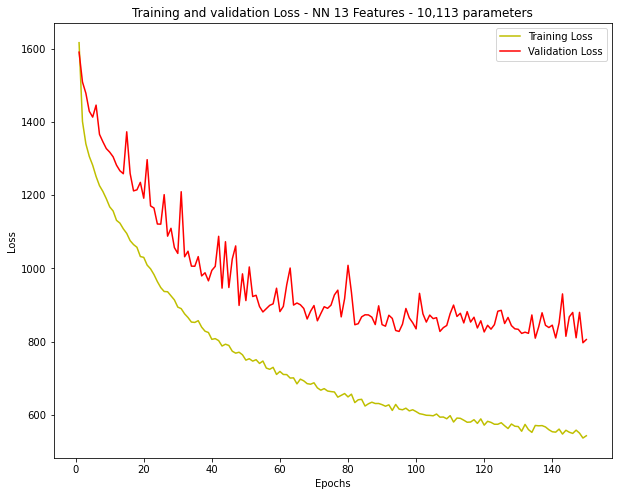

In [103]:
# Plot the training and validation accuracy and loss at each epoch
loss = fit_13_model.history['loss']
val_loss = fit_13_model.history['val_loss']
epochs= range(1, len(loss) + 1)
plt.figure(figsize=(10, 8))
plt.plot(epochs, loss, 'y', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation Loss - NN 13 Features - 10,113 parameters')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show

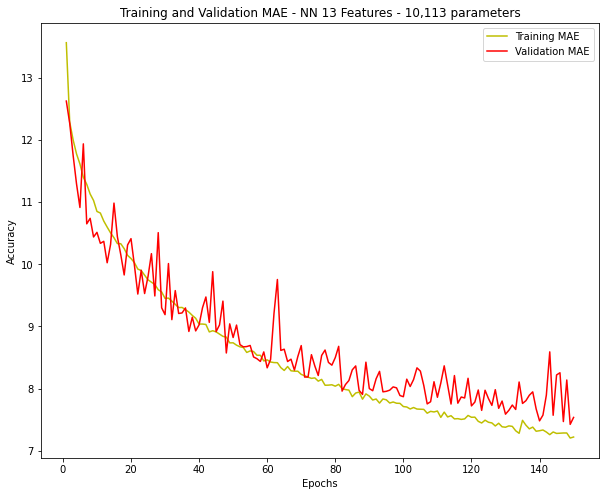

In [104]:
acc = fit_13_model.history['mae']
val_acc = fit_13_model.history['val_mae']
plt.figure(figsize=(10, 8))
plt.plot(epochs, acc, 'y', label='Training MAE')
plt.plot(epochs, val_acc, 'r', label='Validation MAE')
plt.title('Training and Validation MAE - NN 13 Features - 10,113 parameters')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [105]:
# Neural Network evaluation
mse_neural, mae_neural = nn_13.evaluate(X1_test_scaled, y1_test)
print("Mean squared error from neural net: ", mse_neural)
print("Mean absolute error from neural net: ", mae_neural)

781/781 [==============================] - 0s 558us/step - loss: 626.8229 - mae: 7.5756
Mean squared error from neural net:  626.8229370117188
Mean absolute error from neural net:  7.5756425857543945


In [106]:
# Predict on test data
pred_nn13 = nn_13.predict(X1_test_scaled[:5])
print("Predicted values are: ", pred_nn13)
print("Real values are: ", y1_test[:5])

Predicted values are:  [[82.058556]
 [ 0.      ]
 [ 0.      ]
 [50.82926 ]
 [ 0.      ]]
Real values are:  id_row
55668     54.7092
127576     0.0000
125221     0.9099
36631     36.8305
197650     4.9681
Name: new_cases_per_100K, dtype: float64


In [110]:
# # Create a new dataframe with actual and predictions values
# # Scale the whole data SCALED
# X1_scaled = X1_scaler.transform(X1)
# preds_nn13 = nn_13.predict(X1_scaled)
# preds_13_df = pd.DataFrame({"Actual": y, "Predicted": preds_nn13, "Residuals": preds_nn13 - y1})[["Actual", "Predicted", "Residuals"]]
# preds_13_df.head(5)

MemoryError: Unable to allocate 74.3 GiB for an array with shape (99856, 99856) and data type float64

### Code to Import the saved models and their weights

#### Rerun the Model & Load Weights from Checkpoints

In [ ]:
# # Define the model - deep neural net
# number_input_features = len(X_train_scaled[0])
# hidden_nodes_layer1 = 8
# hidden_nodes_layer2 = 5

# # Generate a new Sequential model.
# nn_16 = tf.keras.models.Sequential()

# # Add the input and first hidden layer.
# nn_16.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, 
#                              input_dim=number_input_features, 
#                              activation="relu"))
# # Add second hiddern layer.
# nn_16.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, 
#                              activation="relu"))
# # Output layer.
# nn_16.add(tf.keras.layers.Dense(units=1, activation="relu"))

# # Check the structure of the model.
# nn_16.summary()

In [ ]:
# # Compile the model.
# nn_16.compile(loss="mse", optimizer="adam", metrics=['mae'])

In [ ]:
# # Restore the model weights
# nn_16.load_weights("./Neural_Networks/checkpoints_16_basic/weights.100.hdf5")

In [ ]:
# # Neural Network evaluation
# mse_neural, mae_neural = nn_16.evaluate(X_test_scaled, y_test)
# print("Mean squared error from neural net: ", mse_neural)
# print("Mean absolute error from neural net: ", mae_neural)

#### Export the Model to an HDF5 File

In [111]:
# Export our model to HDF5 file
nn_16.save("./Neural_Networks/nn_16_basic_covid.h5")
nn_16_optimized.save("./Neural_Networks/nn_16_optimized_covid.h5")
nn_16_enhanced.save("./Neural_Networks/nn_16_enhanced_covid.h5")
nn_13.save("./Neural_Networks/nn_13_covid.h5")

#### Importing the Saved Model

In [ ]:
# # Import the model to a new object
# nn_16_imported = tf.keras.models.load_model('./Neural_Networks/nn_16_covid.h5')

In [ ]:
# # Check the structure of the imported model.
# nn_16_imported.summary()

In [ ]:
# # Neural Network evaluation
# mse_neural, mae_neural = nn_16.evaluate(X_test_scaled, y_test, verbose=2)
# print("Mean squared error from neural net: ", mse_neural)
# print("Mean absolute error from neural net: ", mae_neural)